# Create maps showing proportion of population over 65 years old, for each IVT unit catchment

Using the datafile as created from notebook 02_combine_demographic_data.ipynb, create a map of proportion of population over 65 within each IVT unit catchment.

To help with geopandas use https://github.com/MichaelAllen1966/2010_geopandas/blob/main/geopandas_1.ipynb

Import libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import os
from matplotlib.transforms import Bbox
import matplotlib.colors as colors
import random
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

Read in Index of Multiple Deprivation data (per LSOA)

In [2]:
suffix = "_2"
df_lsoa = pd.read_csv(f'./data/collated_data{suffix}.csv')
#df_lsoa.set_index(['LSOA'], inplace=True)

Look at first few rows

In [3]:
df_lsoa.head()

LSOA  admissions closest_ivt_unit  closest_ivt_unit_time  \
0  Welwyn Hatfield 010F    0.666667           SG14AB                   18.7   
1  Welwyn Hatfield 012A    4.000000           SG14AB                   19.8   
2  Welwyn Hatfield 002F    2.000000           SG14AB                   18.7   
3  Welwyn Hatfield 002E    0.666667           SG14AB                   18.7   
4  Welwyn Hatfield 010A    3.333333           SG14AB                   18.7   

  closest_mt_unit  closest_mt_unit_time  mt_transfer_time  ivt_rate  \
0          NW12BU                  36.9              47.2       6.8   
1          NW12BU                  36.9              47.2       6.8   
2          NW12BU                  38.0              47.2       6.8   
3          NW12BU                  36.9              47.2       6.8   
4          NW12BU                  36.9              47.2       6.8   

   IMD2019Score Local Authority District name (2019)  ...  age band males 50  \
0        15.616                      Welwyn Hatfield  ...               53.0   
1        33.313                      Welwyn Hatfield  ...               58.0   
2         7.043                      Welwyn Hatfield  ...               43.0   
3         8.249                      Welwyn Hatfield  ...               42.0   
4        19.271                      Welwyn Hatfield  ...               56.0   

   age band males 55  age band males 60  age band males 65  age band males 70  \
0               62.0               37.0               32.0               27.0   
1               63.0               43.0               36.0               25.0   
2               50.0               51.0               21.0               31.0   
3               63.0               33.0               20.0               15.0   
4               54.0               37.0               32.0               28.0   

   age band males 75  age band males 80  age band males 85  age band males 90  \
0               30.0               15.0                4.0                3.0   
1               14.0               15.0                9.0                7.0   
2                8.0                5.0                8.0                5.0   
3               18.0               18.0                5.0                1.0   
4               21.0               12.0                9.0                2.0   

   age band males 95  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  

[5 rows x 140 columns]

Group data by "closest_ivt_unit" and calculate the weighted average travel time for each IVT catchment area.

https://stackoverflow.com/questions/31521027/groupby-weighted-average-and-sum-in-pandas-dataframe

Calculate new column (over 65 year olds)

In [4]:
cols = ['age band 65','age band 70','age band 75','age band 80','age band 85','age band 90','age band 95']
df_lsoa['age band over 65'] = df_lsoa[cols].sum(axis=1)

In [5]:
# Define a lambda function to compute the weighted mean:
wm = lambda x: np.average(x, weights=df_lsoa.loc[x.index, 'age band over 65'])

# Define a dictionary with the functions to apply for a given column:
# the following is deprecated since pandas 0.20:
# f = {'adjusted_lots': ['sum'], 'price': {'weighted_mean' : wm} }
# df.groupby(["contract", "month", "year", "buys"]).agg(f)

# Groupby and aggregate with namedAgg [1]:
ivt_catchment_ave_travel_time = df_lsoa.groupby(['closest_ivt_unit']).agg(
            over_65_persons=('age band over 65', 'sum'),  
            closest_ivt_time_weighted_mean=('closest_ivt_unit_time', wm))
ivt_catchment_ave_travel_time

over_65_persons  closest_ivt_time_weighted_mean
closest_ivt_unit                                                 
B152TH                   142569.0                       19.868507
B714HJ                   157627.0                       19.297952
BA13NG                    99255.0                       25.123174
BA214AT                   70339.0                       24.252608
BB23HH                    86189.0                       20.274601
...                           ...                             ...
WD180HB                  101877.0                       19.751605
WF14DG                   107876.0                       18.823046
WR51DD                    94935.0                       22.095381
WV100QP                  121829.0                       19.144571
YO318HE                  115821.0                       30.166710

[113 rows x 2 columns]

Map the data.

Load IVT catchment shape file (created in notebook "03_create_ivt_catchment_shapefile_and_map.ipynb" by dissolving LSOA polygons that are in the same IVT unit catchment).

https://geopandas.org/aggregation_with_dissolve.html

The following will load the shape file of the catchments for the IVT units in England and Wales into a GeoPandas DataFrame. Note that we can set the crs (Coordinate Reference System) when loading a GeoPandas DataFrame. EPSG:27700 is the crs to use when geography is in BNG (British National Grid Eastings and Northings).

EPSG:27700 OSGB 1936 / British National Grid -- United Kingdom Ordnance Survey. Co-ordinates are in Eastings (X) and Northings (Y). EPSG:4326 WGS 84 -- WGS84 - World Geodetic System 1984. Co-ordinates are in Longitude (X) and Latitude (Y). EPSG:3857 - projection for displaying lat/long as a flat map

In [6]:
filename = f"data/ivt_catchment{suffix}.shp"
exist = os.path.exists(filename)

if exist:
    # Read in
    gdf_ivt_catchment = gpd.read_file(filename, crs='EPSG:27700')
else:
    print('Run "03_create_ivt_catchment_shapefile_and_map.ipynb" first')
gdf_ivt_catchment.head()

closest_iv                           LSOA11NM   LSOA11CD  \
0     B152TH                    Birmingham 067A  E01008881   
1     B714HJ                    Birmingham 037A  E01008899   
2     BA13NG  Bath and North East Somerset 007A  E01014370   
3    BA214AT                    East Devon 005A  E01019886   
4     BB23HH                        Bolton 001B  E01004803   

                           LSOA11NMW  \
0                    Birmingham 067A   
1                    Birmingham 037A   
2  Bath and North East Somerset 007A   
3                    East Devon 005A   
4                        Bolton 001B   

                                            geometry  
0  MULTIPOLYGON (((416346.099 267790.717, 416204....  
1  MULTIPOLYGON (((395851.844 272307.409, 395947....  
2  POLYGON ((391028.906 148190.250, 391138.688 14...  
3  MULTIPOLYGON (((330557.896 98588.730, 330365.5...  
4  POLYGON ((371685.702 414415.737, 371465.678 41...

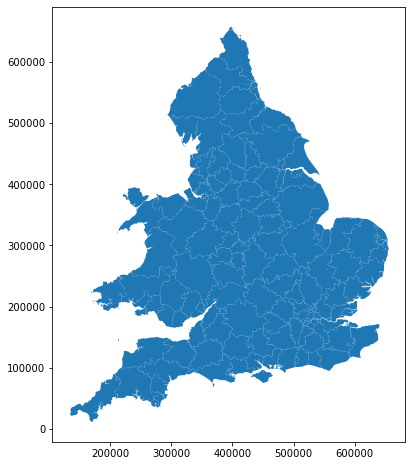

In [7]:
gdf_ivt_catchment.plot(figsize=(8,8));

Add travel time data, joining based on 'closest_ivt_unit'

In [8]:
gdf_ivt_catchment.set_index(['closest_iv'], inplace=True)
gdf_ivt_catchment = gdf_ivt_catchment.join(ivt_catchment_ave_travel_time['closest_ivt_time_weighted_mean']).reset_index()
gdf_ivt_catchment.head()

closest_iv                           LSOA11NM   LSOA11CD  \
0     B152TH                    Birmingham 067A  E01008881   
1     B714HJ                    Birmingham 037A  E01008899   
2     BA13NG  Bath and North East Somerset 007A  E01014370   
3    BA214AT                    East Devon 005A  E01019886   
4     BB23HH                        Bolton 001B  E01004803   

                           LSOA11NMW  \
0                    Birmingham 067A   
1                    Birmingham 037A   
2  Bath and North East Somerset 007A   
3                    East Devon 005A   
4                        Bolton 001B   

                                            geometry  \
0  MULTIPOLYGON (((416346.099 267790.717, 416204....   
1  MULTIPOLYGON (((395851.844 272307.409, 395947....   
2  POLYGON ((391028.906 148190.250, 391138.688 14...   
3  MULTIPOLYGON (((330557.896 98588.730, 330365.5...   
4  POLYGON ((371685.702 414415.737, 371465.678 41...   

   closest_ivt_time_weighted_mean  
0                       19.868507  
1                       19.297952  
2                       25.123174  
3                       24.252608  
4                       20.274601

Mapping data with MatPlotLib

Using MatPlotLib gives us more power than the GeoPandas DataFrame plot method.

Read in hospital data
(Stroke Team, SSNAP name, Easting, Northing)

In [9]:
gdf_units = gpd.read_file('./data/stroke_hospitals_2022.csv')

gdf_units["geometry"] = gpd.points_from_xy(
        gdf_units.Easting, gdf_units.Northing)
gdf_units = gdf_units.set_crs(epsg=27700)

# limit dataset to the hospitals using thrombolysis
mask = gdf_units['Use_IVT']=="1"
gdf_units = gdf_units[mask]
gdf_units.head()

Postcode Hospital_name Use_IVT Use_MT  Country Strategic Clinical Network  \
0   RM70AG        RM70AG       1      1  England                 London SCN   
1    E11BB         E11BB       1      1  England                 London SCN   
2   SW66SX        SW66SX       1      1  England                 London SCN   
3   SE59RW        SE59RW       1      1  England                 London SCN   
4   BR68ND        BR68ND       1      0  England                 London SCN   

                                Health Board / Trust  \
0  Barking; Havering and Redbridge University Hos...   
1                             Barts Health NHS Trust   
2              Imperial College Healthcare NHS Trust   
3       King's College Hospital NHS Foundation Trust   
4       King's College Hospital NHS Foundation Trust   

                                     Stroke Team  \
0                      Queen's Hospital, Romford   
1                      The Royal London Hospital   
2                 Charing Cross Hospital, London   
3                King's College Hospital, London   
4  Princess Royal University Hospital; Orpington   

                                SSNAP name Admissions 21/22 Thrombolysis  \
0             Queens Hospital Romford HASU              981          117   
1               Royal London Hospital HASU              861          115   
2              Charing Cross Hospital HASU             1147          113   
3             King's College Hospital HASU              824          124   
4  Princess Royal University Hospital HASU              847          113   

  ivt_rate Easting Northing Neuroscience 30 England Thrombectomy Example  \
0     11.9  551118   187780            1                               0   
1     13.4  534829   181798            1                               1   
2      9.9  524226   176487            1                               1   
3       15  532536   176228            1                               0   
4     13.3  543443   165032            0                               0   

    hospital_city Notes                       geometry  
0         Romford        POINT (551118.000 187780.000)  
1    Royal London        POINT (534829.000 181798.000)  
2   Charing Cross        POINT (524226.000 176487.000)  
3   Kings College        POINT (532536.000 176228.000)  
4  Princess Royal        POINT (543443.000 165032.000)

In [10]:
# When using base maps convert data to epsg:3857
gdf_ivt_catchment = gdf_ivt_catchment.to_crs(epsg=3857)
gdf_units = gdf_units.to_crs(epsg=3857)

In [11]:
def add_nonoverlapping_text_labels(gdf_units, ax, col, y_step=0.05, fontsize=7):
    """
    #https://stackoverflow.com/questions/43916834/matplotlib-dynamically-change-text-position


    """

    text_rectangles = []

    # Better results if the labels are sorted descending in the y axis
    gdf_units['sort_by'] = gdf_units.geometry.y
    gdf_units.sort_values("sort_by", ascending=False, inplace=True)
    del gdf_units["sort_by"]

    # Add labels
    for x, y, label in zip(
        gdf_units.geometry.x, gdf_units.geometry.y, gdf_units[col]):
            text = ax.annotate(label, xy=(x, y), xytext=(8, 8), 
                        textcoords="offset points", fontsize=fontsize, 
                        bbox=dict(facecolor='w', alpha=0.3, edgecolor='none', boxstyle="round", pad=0.1))
            x, y = text.get_position()
            new_x = x - 2
            text.set_position((new_x, y))
                    
            rect = text.get_window_extent()

            for other_rect in text_rectangles:
                while Bbox.intersection(rect, other_rect):  # overlapping
                    x, y = text.get_position()
                    new_y = y - y_step
                    text.set_position((x, new_y))
                    rect = text.get_window_extent()
            text_rectangles.append(rect)
    return (ax)

In [12]:
eng_wales_bounds = gdf_ivt_catchment.bounds
eng_wales_bounds = eng_wales_bounds.merge(gdf_ivt_catchment['closest_iv'],how = 'left',
                      left_on = eng_wales_bounds.index,
                      right_on = gdf_ivt_catchment.index)
eng_wales_bounds = eng_wales_bounds.set_index('closest_iv')
eng_wales_bounds.drop('key_0', axis = 1, inplace = True)
eng_wales_bounds.head()

minx          miny           maxx          maxy
closest_iv                                                          
B152TH     -228159.802962  6.840962e+06 -186486.338536  6.891587e+06
B714HJ     -230754.673759  6.862190e+06 -174024.968174  6.926919e+06
BA13NG     -301440.775912  6.639528e+06 -220910.832420  6.742989e+06
BA214AT    -338714.448556  6.574692e+06 -241766.759874  6.661788e+06
BB23HH     -293523.883294  7.097870e+06 -227656.460963  7.179456e+06

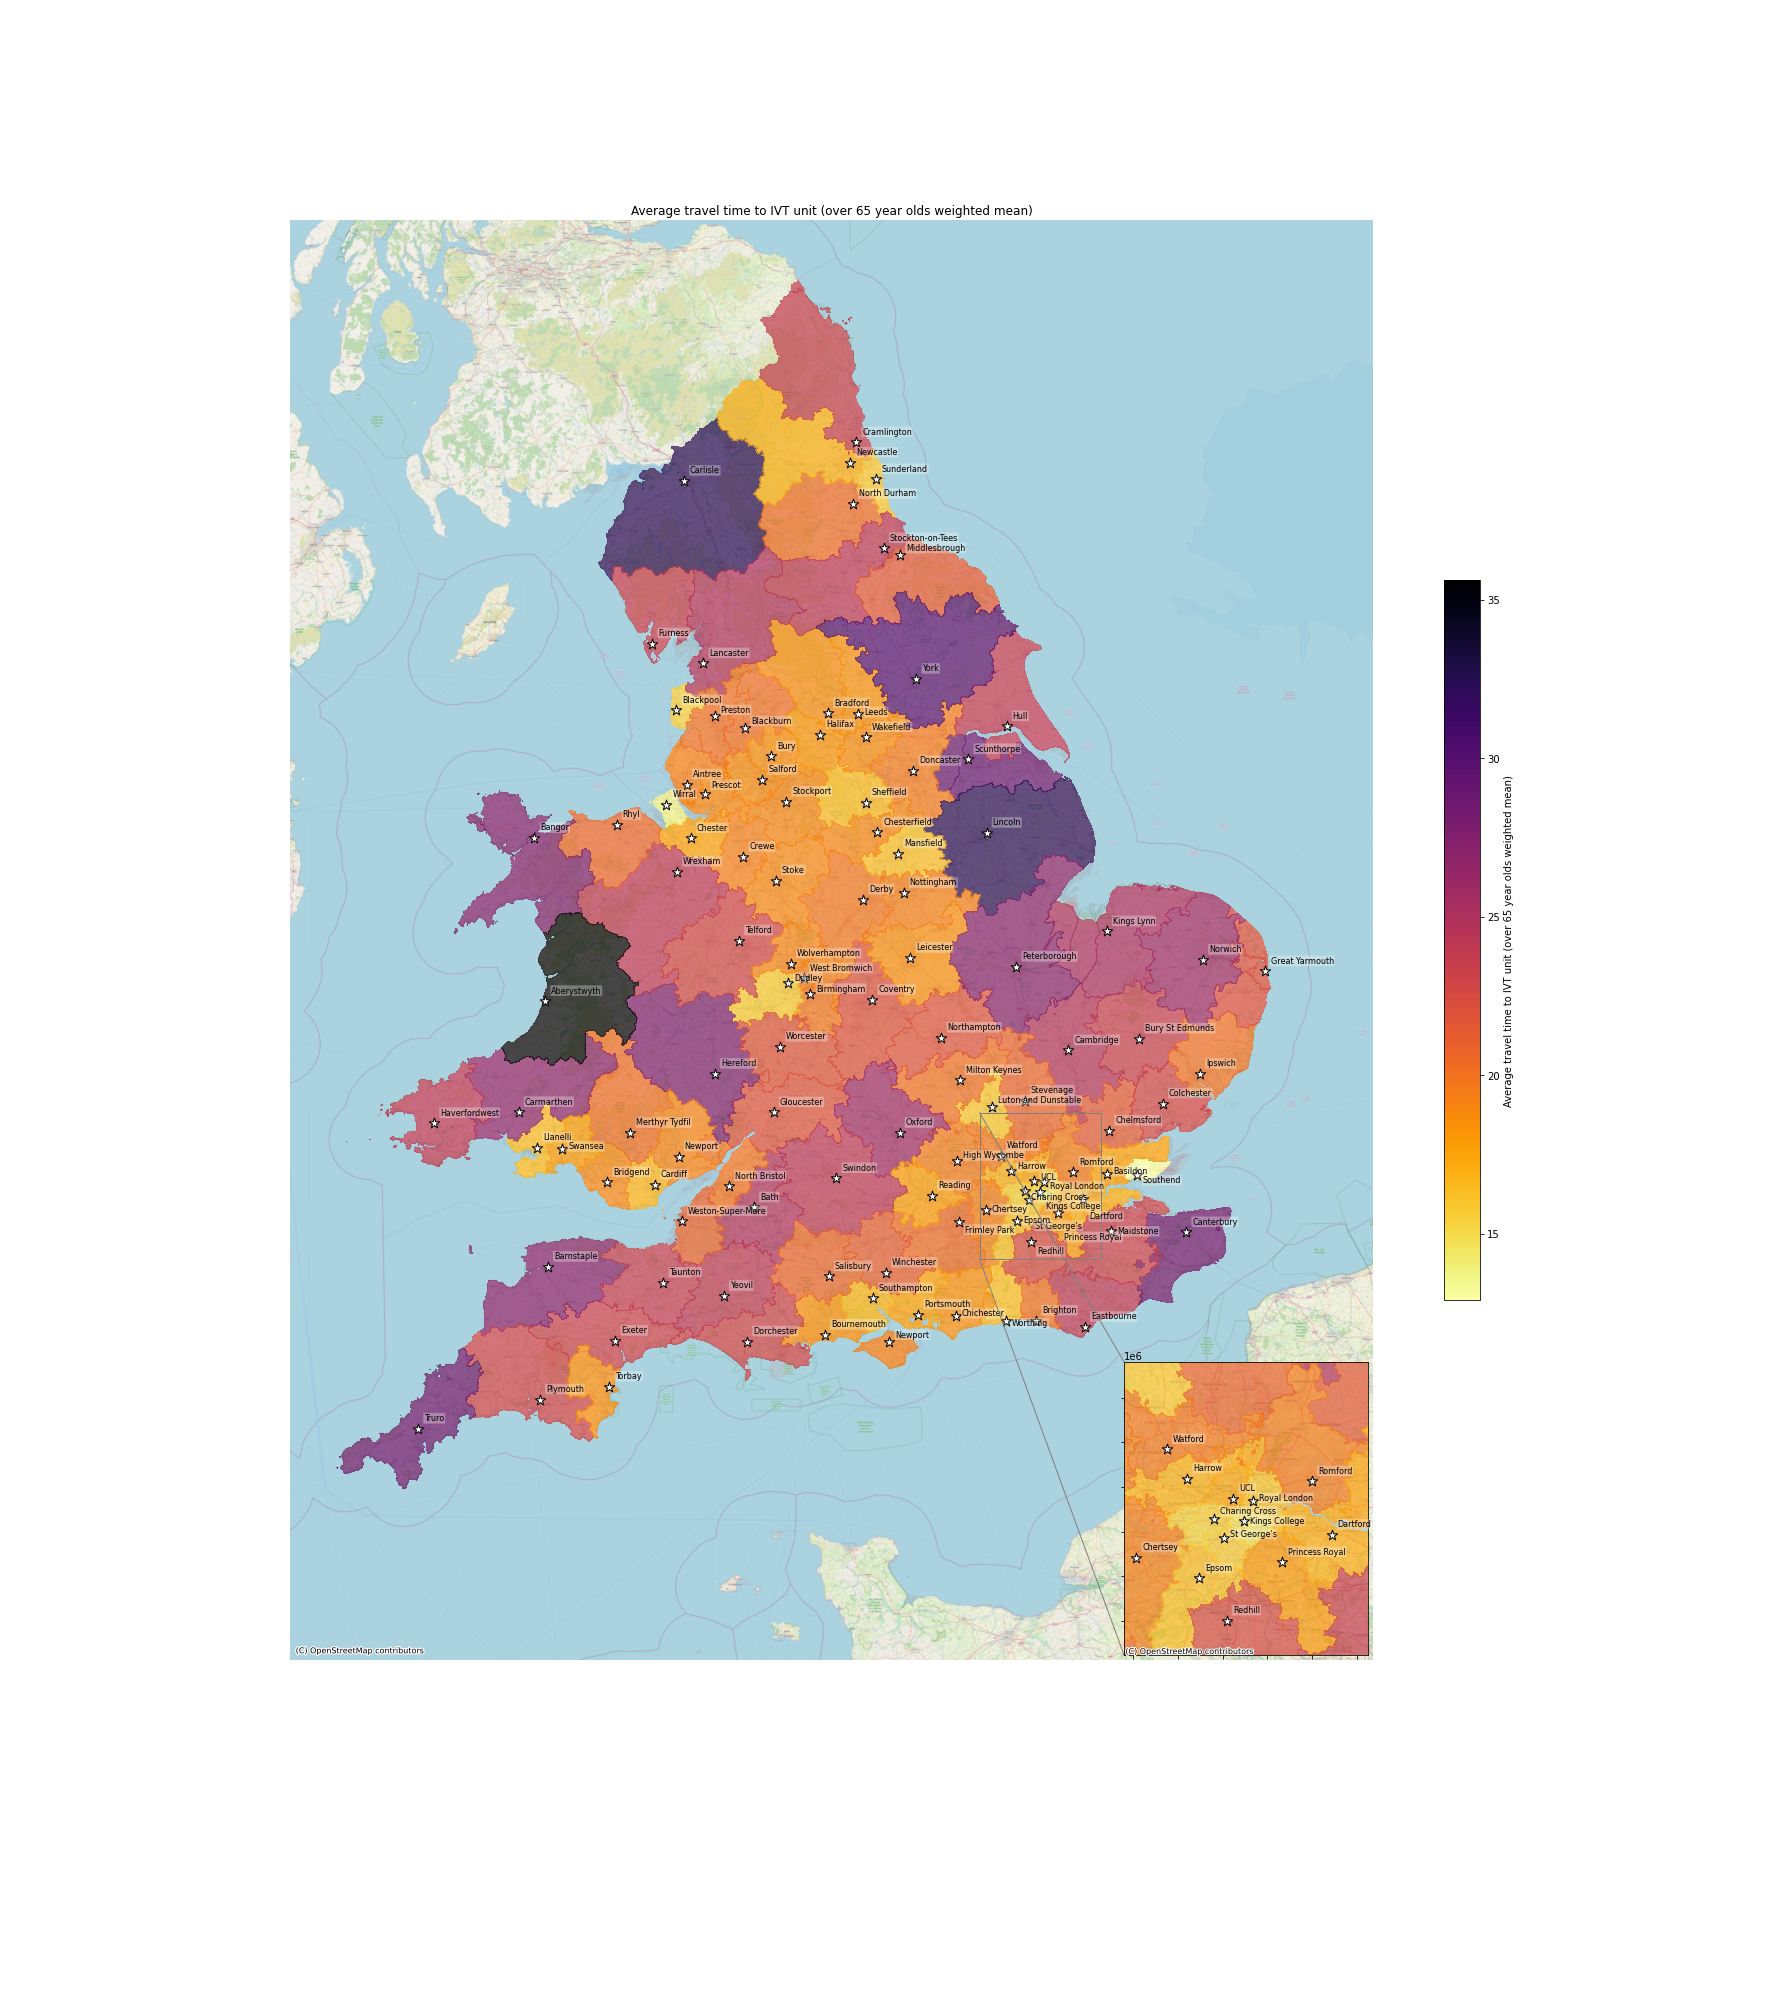

In [13]:
show_labels = True

col = 'closest_ivt_time_weighted_mean'
col_readable = 'Average travel time to IVT unit (over 65 year olds weighted mean)'

fig, ax = plt.subplots(figsize=(20, 20)) # Make max dimensions 10x10 inch
gdf_ivt_catchment.plot(ax=ax, # Set which axes to use for plot (only one here)
                 column=col, # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 linewidth=0.0,# Use linewidth=0 to hide boarder lines
#                 vmin=0, # Manual scale min (remove to make automatic)
#                 vmax=70, # Manual scale max (remove to make automatic)
                 cmap='inferno_r', # Colour map to use
                 # Adjust size of colourmap key, and add label
                 legend_kwds={'shrink':0.5, 'label':f'{col_readable}'},
                 # Set to display legend
                 legend=True,
                 # Set transparancy (to help reveal basemap
                 alpha = 0.70)

# Plot location of hospitals
gdf_units.plot(ax=ax, edgecolor='k', facecolor='w', markersize=120, 
               marker='*')

if show_labels:
    ax = add_nonoverlapping_text_labels(gdf_units, ax, 'hospital_city',
                                        y_step=0.05, fontsize=8)

        
# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
ctx.add_basemap(ax, 
                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)


# give some more space at bottom for london inset map
ax.set_ylim(ax.get_ylim()[0] - 100000, ax.get_ylim()[1])
# give some more space at right for hospital name label
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + 50000)

# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
ctx.add_basemap(ax, 
                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)

# Insert an inset map (loc=4 places it bottom right)
axins = zoomed_inset_axes(ax, 2, loc=4)

# Identify london hospitals to go in the inset map
mask = gdf_units["Strategic Clinical Network"]=="London SCN"
london_hospitals = gdf_units["Hospital_name"][mask].to_list()

# identify map area to plot in the inset map
# initialise exteme values
minx_ = np.inf
miny_ = np.inf
maxx_ = 0
maxy_ = 0
# Find min and max x and y for the london hospitals
for h in london_hospitals:
    minx,miny,maxx,maxy =  eng_wales_bounds.loc[h]
    minx_ = min(minx_, minx)
    miny_ = min(miny_, miny)
    maxx_ = max(maxx_, maxx)
    maxy_ = max(maxy_, maxy)

# Set extent of inset map
axins.set_xlim(minx_, maxx_)
axins.set_ylim(miny_, maxy_)

# Define lines connecting inset map to main map
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")

# Plot zoom window
gdf_ivt_catchment.plot(ax=axins, # Set which axes to use for plot (only one here)
                 column=col, # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 linewidth=0.0,# Use linewidth=0 to hide boarder lines
                 cmap='inferno_r', # Colour map to use
                 # Adjust size of colourmap key, and add label
#                 legend_kwds={'shrink':0.5, 'label':f'{col_readable}'},
                 # Set to display legend
#                 legend=True,
                 # Set transparancy (to help reveal basemap
                 alpha = 0.70)

# Plot location of hospitals
gdf_units.plot(ax=axins, edgecolor='k', facecolor='w', markersize=120, 
               marker='*')

# Label hospitals
if show_labels:
    axins = add_nonoverlapping_text_labels(gdf_units, axins, 'hospital_city',
                                        y_step=0.05, fontsize=8)

# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
ctx.add_basemap(ax=axins, 
                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)

# Remove x and y ticks
plt.setp(axins.get_xticklabels(), visible=False)
plt.setp(axins.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

ax.set_axis_off() # Turn of axis line and numbers
ax.set_title(f'{col_readable}')
# Adjust for printing
ax.margins(0)
ax.apply_aspect()
plt.subplots_adjust(left=0.01, right=1.0, bottom=0.0, top=1.0)
plt.savefig(f'map_{col}{suffix}.jpg', dpi=300) # Save figure
plt.show()

In [14]:
print(f"The range of {col_readable} across the {gdf_ivt_catchment.shape[0]} catchments is: {round(gdf_ivt_catchment[col].min(),2)} to {round(gdf_ivt_catchment[col].max(),2)}")
print(f"Median: {round(gdf_ivt_catchment[col].median(),2)}")

The range of Average travel time to IVT unit (over 65 year olds weighted mean) across the 113 catchments is: 12.89 to 35.61
Median: 20.06


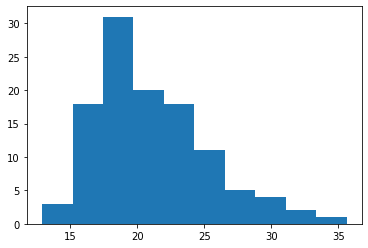

In [15]:
plt.hist(gdf_ivt_catchment[col]);

## Of over 65 yrs old population, what proportion of the catchment is within 30 minutes?

Create column with the population that are over 65 years old and are within 30 minutes of their nearest IVT centre

In [16]:
mask = df_lsoa['closest_ivt_unit_time'] <= 30
#temp_series = pd.DataFrame(0, index=np.arange(len(df_lsoa)), columns=[['age band over 65 within 30mins']])
temp_series = pd.DataFrame(0, index=df_lsoa.index, columns=[['age band over 65 within 30mins']])
temp_series[mask] = df_lsoa['age band over 65'][mask]
df_lsoa['age band over 65 within 30mins'] = temp_series

Groupby nearest IVT centre and sum each the total population over 65 years old, and the population over 65 years old and within 30 minutes. Calculate the proportion of the 65 year old population that are within 30 minutes.

In [17]:
# Groupby and sum
ivt_catchment_propn_over65_within_30mins = df_lsoa.groupby(['closest_ivt_unit'])[['age band over 65','age band over 65 within 30mins']].sum()
ivt_catchment_propn_over65_within_30mins['propn_over65_within_30mins'] = (
            ivt_catchment_propn_over65_within_30mins['age band over 65 within 30mins'] / 
            ivt_catchment_propn_over65_within_30mins['age band over 65'])
ivt_catchment_propn_over65_within_30mins

age band over 65  age band over 65 within 30mins  \
closest_ivt_unit                                                     
B152TH                    142569.0                        136431.0   
B714HJ                    157627.0                        137513.0   
BA13NG                     99255.0                         62886.0   
BA214AT                    70339.0                         43826.0   
BB23HH                     86189.0                         79922.0   
...                            ...                             ...   
WD180HB                   101877.0                         94941.0   
WF14DG                    107876.0                        107409.0   
WR51DD                     94935.0                         82259.0   
WV100QP                   121829.0                        110530.0   
YO318HE                   115821.0                         65288.0   

                  propn_over65_within_30mins  
closest_ivt_unit                              
B152TH                              0.956947  
B714HJ                              0.872395  
BA13NG                              0.633580  
BA214AT                             0.623068  
BB23HH                              0.927288  
...                                      ...  
WD180HB                             0.931918  
WF14DG                              0.995671  
WR51DD                              0.866477  
WV100QP                             0.907255  
YO318HE                             0.563697  

[113 rows x 3 columns]

Join column to the shapefile for IVT catchment

In [18]:
gdf_ivt_catchment.set_index(['closest_iv'], inplace=True)
gdf_ivt_catchment = gdf_ivt_catchment.join(ivt_catchment_propn_over65_within_30mins['propn_over65_within_30mins']).reset_index()
gdf_ivt_catchment.head()

closest_iv                           LSOA11NM   LSOA11CD  \
0     B152TH                    Birmingham 067A  E01008881   
1     B714HJ                    Birmingham 037A  E01008899   
2     BA13NG  Bath and North East Somerset 007A  E01014370   
3    BA214AT                    East Devon 005A  E01019886   
4     BB23HH                        Bolton 001B  E01004803   

                           LSOA11NMW  \
0                    Birmingham 067A   
1                    Birmingham 037A   
2  Bath and North East Somerset 007A   
3                    East Devon 005A   
4                        Bolton 001B   

                                            geometry  \
0  MULTIPOLYGON (((-196108.670 6856006.932, -1963...   
1  MULTIPOLYGON (((-229576.464 6863444.064, -2294...   
2  POLYGON ((-237096.214 6662581.601, -236920.941...   
3  MULTIPOLYGON (((-332442.946 6582944.980, -3327...   
4  POLYGON ((-270459.822 7099547.703, -270828.685...   

   closest_ivt_time_weighted_mean  propn_over65_within_30mins  
0                       19.868507                    0.956947  
1                       19.297952                    0.872395  
2                       25.123174                    0.633580  
3                       24.252608                    0.623068  
4                       20.274601                    0.927288

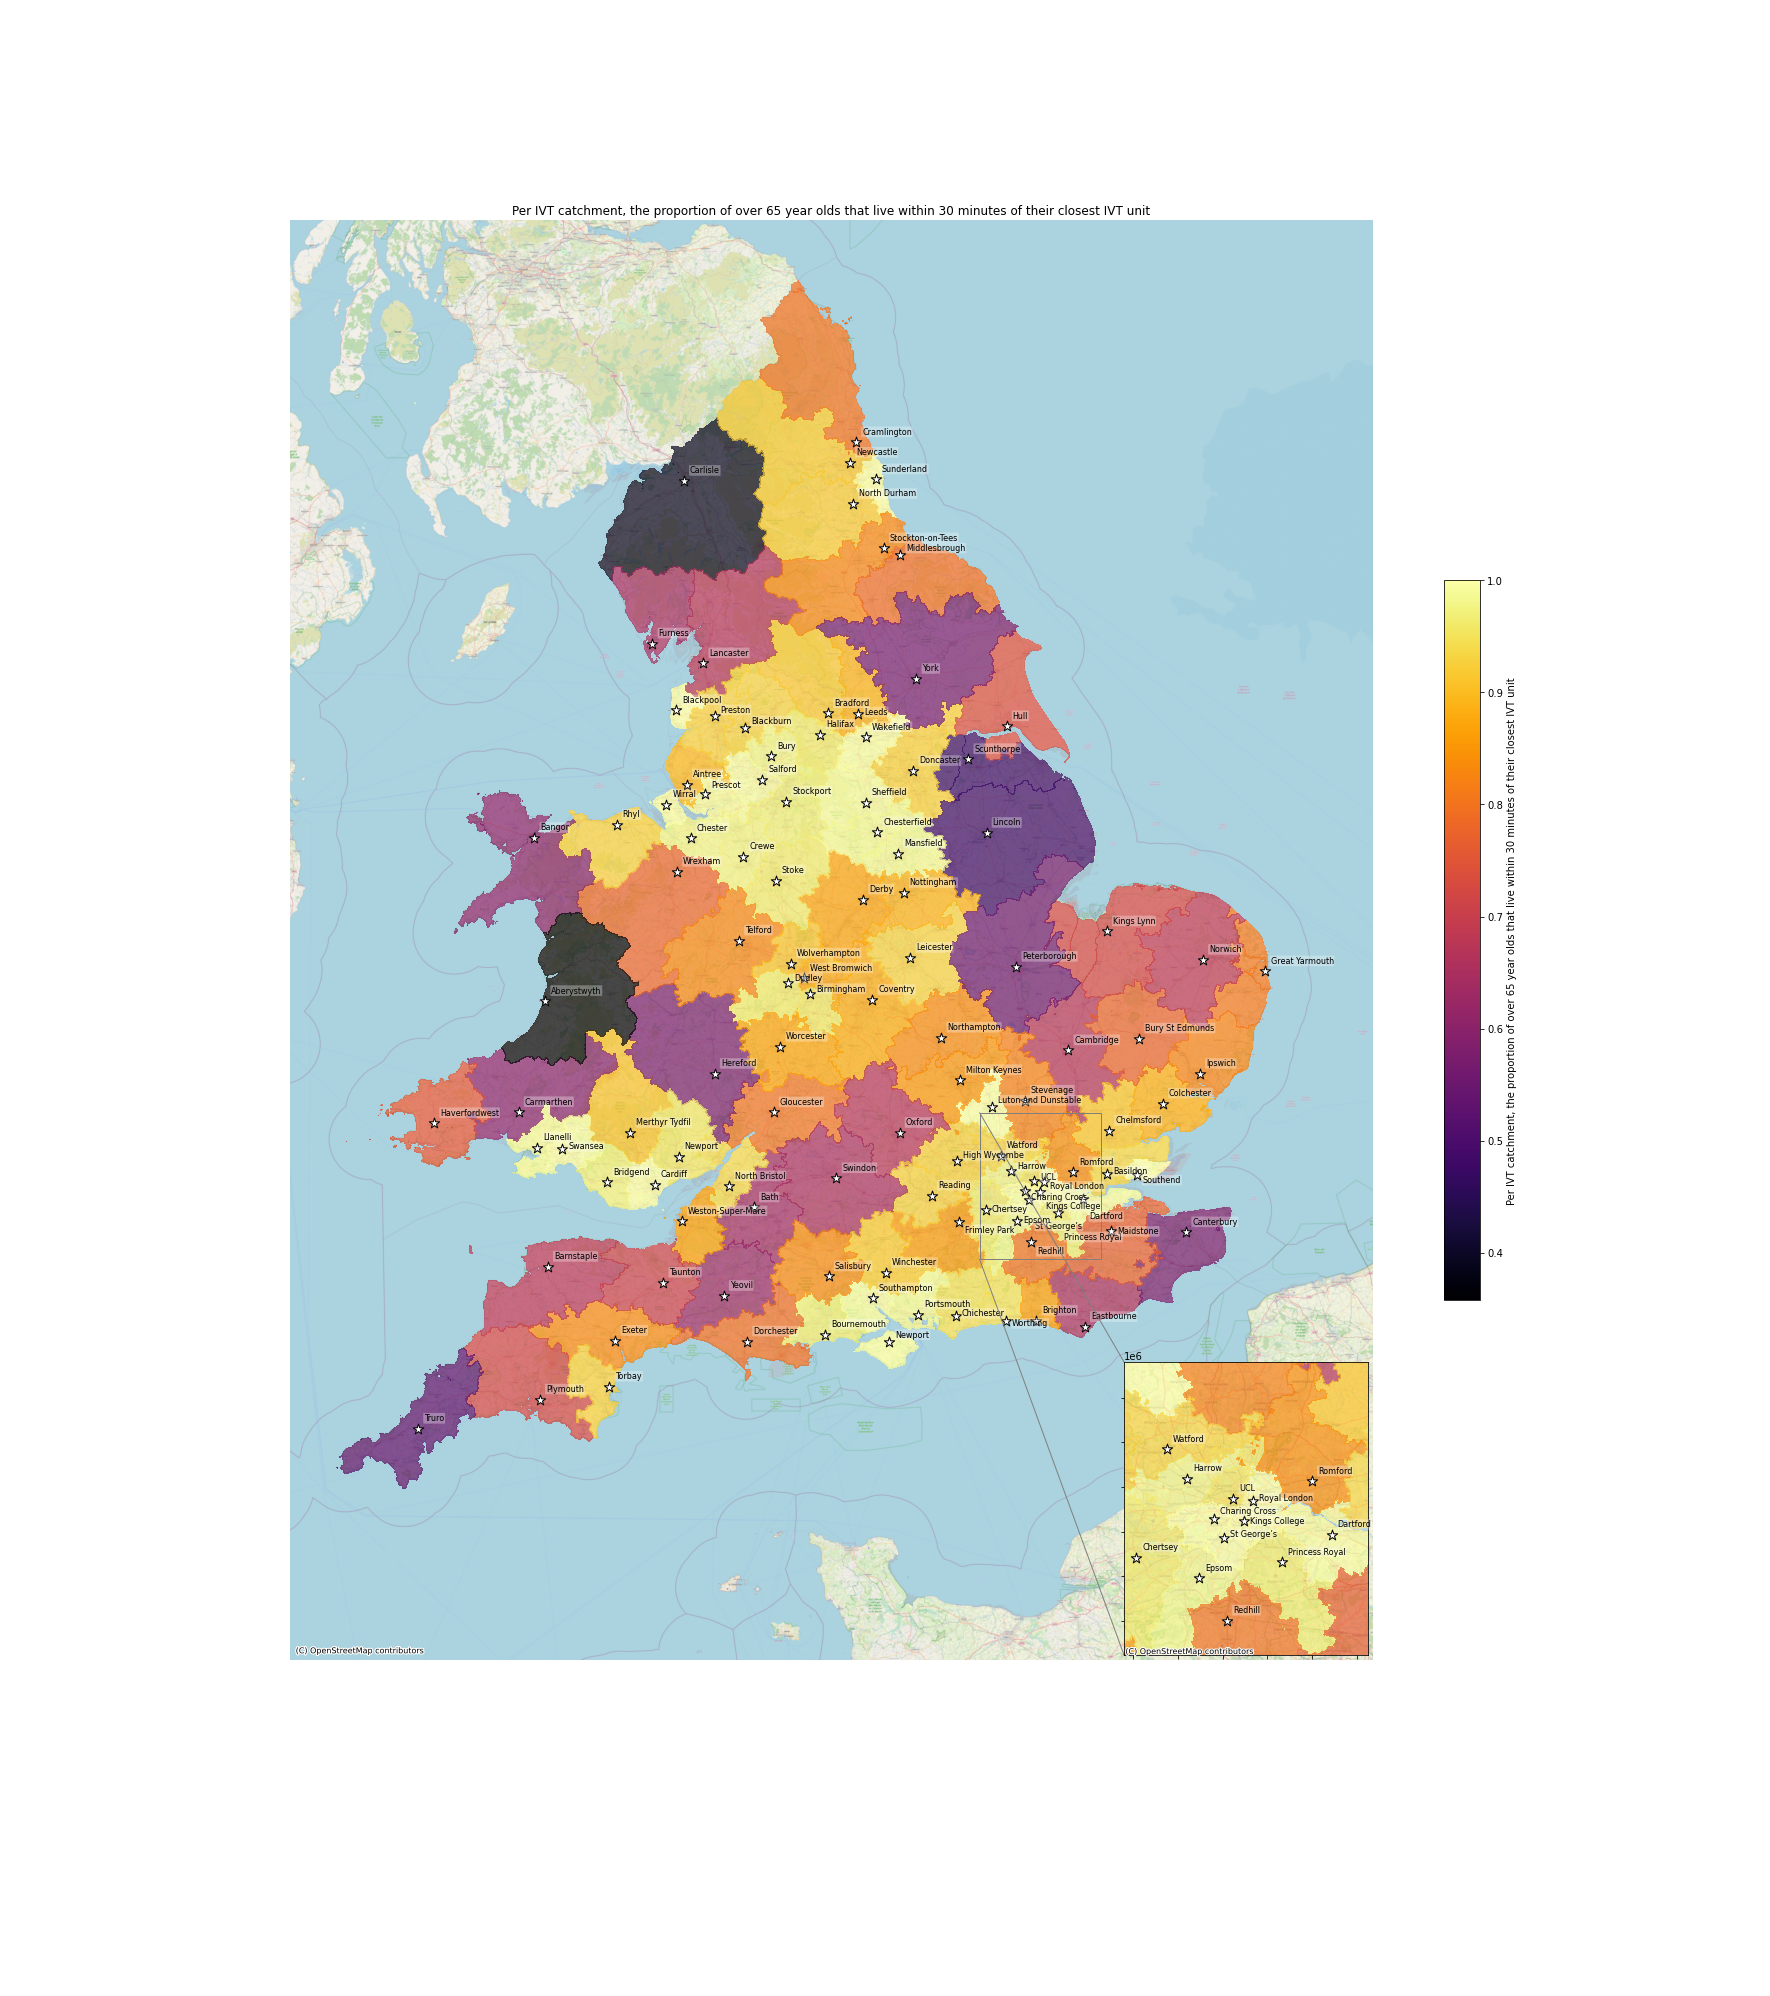

In [19]:
show_labels = True

col = 'propn_over65_within_30mins'
col_readable = 'Per IVT catchment, the proportion of over 65 year olds that live within 30 minutes of their closest IVT unit'

fig, ax = plt.subplots(figsize=(20, 20)) # Make max dimensions 10x10 inch
gdf_ivt_catchment.plot(ax=ax, # Set which axes to use for plot (only one here)
                 column=col, # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 linewidth=0.0,# Use linewidth=0 to hide boarder lines
#                 vmin=0, # Manual scale min (remove to make automatic)
#                 vmax=70, # Manual scale max (remove to make automatic)
                 cmap='inferno', # Colour map to use
                 # Adjust size of colourmap key, and add label
                 legend_kwds={'shrink':0.5, 'label':f'{col_readable}'},
                 # Set to display legend
                 legend=True,
                 # Set transparancy (to help reveal basemap
                 alpha = 0.70)

# Plot location of hospitals
gdf_units.plot(ax=ax, edgecolor='k', facecolor='w', markersize=120, 
               marker='*')

if show_labels:
    ax = add_nonoverlapping_text_labels(gdf_units, ax, 'hospital_city',
                                        y_step=0.05, fontsize=8)

        
# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
ctx.add_basemap(ax, 
                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)


# give some more space at bottom for london inset map
ax.set_ylim(ax.get_ylim()[0] - 100000, ax.get_ylim()[1])
# give some more space at right for hospital name label
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + 50000)

# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
ctx.add_basemap(ax, 
                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)

# Insert an inset map (loc=4 places it bottom right)
axins = zoomed_inset_axes(ax, 2, loc=4)

# Identify london hospitals to go in the inset map
mask = gdf_units["Strategic Clinical Network"]=="London SCN"
london_hospitals = gdf_units["Hospital_name"][mask].to_list()

# identify map area to plot in the inset map
# initialise exteme values
minx_ = np.inf
miny_ = np.inf
maxx_ = 0
maxy_ = 0
# Find min and max x and y for the london hospitals
for h in london_hospitals:
    minx,miny,maxx,maxy =  eng_wales_bounds.loc[h]
    minx_ = min(minx_, minx)
    miny_ = min(miny_, miny)
    maxx_ = max(maxx_, maxx)
    maxy_ = max(maxy_, maxy)

# Set extent of inset map
axins.set_xlim(minx_, maxx_)
axins.set_ylim(miny_, maxy_)

# Define lines connecting inset map to main map
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")

# Plot zoom window
gdf_ivt_catchment.plot(ax=axins, # Set which axes to use for plot (only one here)
                 column=col, # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 linewidth=0.0,# Use linewidth=0 to hide boarder lines
                 cmap='inferno', # Colour map to use
                 # Adjust size of colourmap key, and add label
#                 legend_kwds={'shrink':0.5, 'label':f'{col_readable}'},
                 # Set to display legend
#                 legend=True,
                 # Set transparancy (to help reveal basemap
                 alpha = 0.70)

# Plot location of hospitals
gdf_units.plot(ax=axins, edgecolor='k', facecolor='w', markersize=120, 
               marker='*')

# Label hospitals
if show_labels:
    axins = add_nonoverlapping_text_labels(gdf_units, axins, 'hospital_city',
                                        y_step=0.05, fontsize=8)

# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
ctx.add_basemap(ax=axins, 
                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)

# Remove x and y ticks
plt.setp(axins.get_xticklabels(), visible=False)
plt.setp(axins.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

ax.set_axis_off() # Turn of axis line and numbers
ax.set_title(f'{col_readable}')
# Adjust for printing
ax.margins(0)
ax.apply_aspect()
plt.subplots_adjust(left=0.01, right=1.0, bottom=0.0, top=1.0)
plt.savefig(f'map_{col}{suffix}.jpg', dpi=300) # Save figure
plt.show()

In [20]:
print(f"The range of {col_readable} across the {gdf_ivt_catchment.shape[0]} catchments is: {round(gdf_ivt_catchment[col].min(),2)} to {round(gdf_ivt_catchment[col].max(),2)}")
print(f"Median: {round(gdf_ivt_catchment[col].median(),2)}")

The range of Per IVT catchment, the proportion of over 65 year olds that live within 30 minutes of their closest IVT unit across the 113 catchments is: 0.36 to 1.0
Median: 0.91


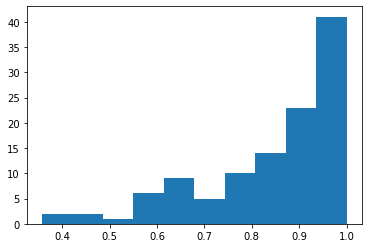

In [21]:
plt.hist(gdf_ivt_catchment[col]);